420 777 24 500
324 191 645 551
[ 24 624] [298 420] [500 569] [169 777]
417 767 570 1032
802 797 594 590
[570 572] [780 417] [1032  607] [770 767]
413 771 1104 1598
1295 1413 550 632
[1104  534] [1268  413] [1598  649] [1384  771]
63.637855970537466 74.44051458333334



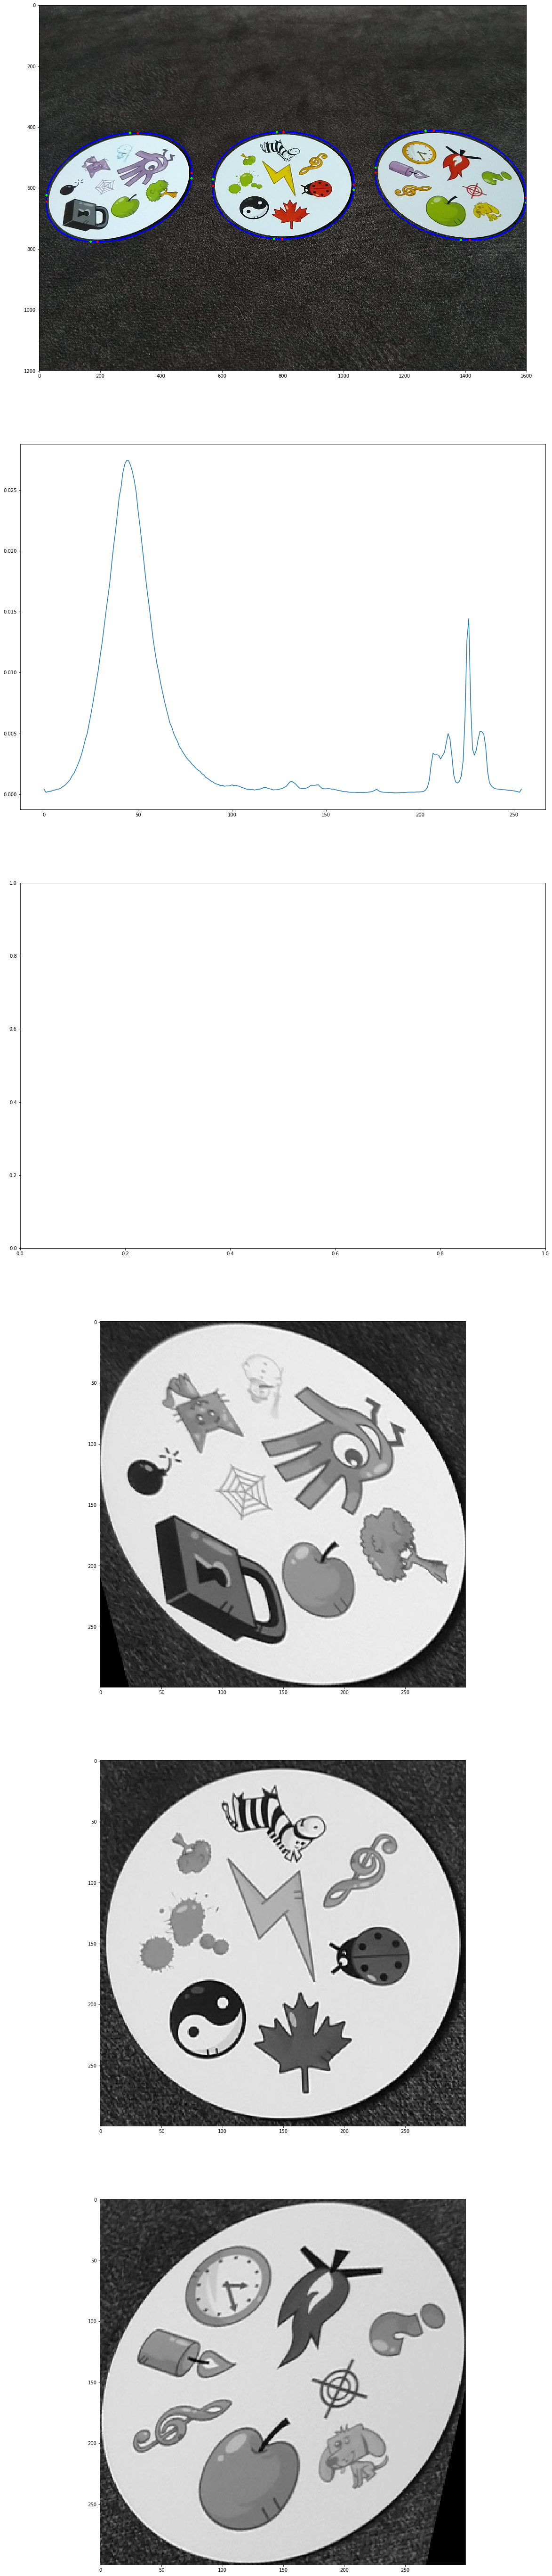

In [69]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from skimage import measure
import cv2

def coords(contour, i):
    xmin = int(np.amin(contour[:,0,1]))
    xmax = int(np.amax(contour[:,0,1]))
    ymin = int(np.amin(contour[:,0,0]))
    ymax = int(np.amax(contour[:,0,0]))
    return xmin-i, xmax+i, ymin-i, ymax+i

def dil(img):
    how_many = int((img.shape[1]-600)*((12.0-3.0)/2408.0)+3)
    for i in range(how_many):
        img = mp.erosion(img)
    return img

def treshhold(img):
    x = np.percentile(img, 3.5)
    std = np.std(img)
    if (std < 0.146): x-=(10.0/255.0)
    else:x+=(50.0/255.0)
    if (img.shape[1]>1500): x-=(5.0/255.0)
    if (std < 0.098): x-=(50.0/255.0)
    return (img > x) * 1.0
    

def increase_contrast(img):
    percmin=0.3
    percmax=2.0
    MIN = np.percentile(img, percmin)
    MAX = np.percentile(img, 100-percmax)
    norm = (img - MIN) / (MAX - MIN)
    norm[norm[:,:] > 1] = 1
    norm[norm[:,:] < 0] = 0
    return norm
    
def gamma_filter(img):
    MIN = 0.4628
    MAX = 0.9746
    gamma_MIN = 0.2
    gamma_MAX = 0.7
    mean = np.mean(img)
    gamma = (mean-MIN)*((gamma_MAX - gamma_MIN)/(MAX-MIN)) + gamma_MIN
    return img**gamma

def to_gray(img):
    temp = rgb2hsv(img)
    temp[:,:,1] = 0
    temp2 = hsv2rgb(temp)
    return rgb2gray(temp2)

def process(img, i):
    img = to_gray(img)
    img = gamma_filter(img)
    img = gamma_filter(img)
    img = increase_contrast(img)
    img = treshhold(img)
    img = dil(img)
    return img
            

fig, ax = plt.subplots(6, 1, figsize=(20,100))


filename = "./img/dobble07.jpg"
img_col = cv2.imread(filename)
img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(filename, 0)

histo, x = np.histogram(img_as_ubyte(img_gray), range(0, 256), density=True)
ax[1].plot(histo)


ret, th1 = cv2.threshold(img_gray, 110, 255, cv2.THRESH_BINARY)
th1 = cv2.erode(th1,np.ones((3,3),np.uint8),iterations = 2)
th1 = cv2.dilate(th1, np.ones((3,3),np.uint8), iterations = 10)

im2, contours, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for i, cnt in enumerate(contours):
    xmin, xmax, ymin, ymax = coords(cnt, 0)
    if (xmax-xmin > 40 or ymax-ymin > 40):
        cv2.drawContours(img_col, [cnt], 0, (0,0,255), 4)
        
        leftmost = cnt[cnt[:,:,0].argmin()][0]
        rightmost = cnt[cnt[:,:,0].argmax()][0]
        topmost = cnt[cnt[:,:,1].argmin()][0]
        bottommost = cnt[cnt[:,:,1].argmax()][0]
        
        print(xmin, xmax, ymin, ymax)
        
        xminy = int(np.mean([y for y, x in cnt[:,0,:] if x == xmin]))
        xmaxy = int(np.mean([y for y, x in cnt[:,0,:] if x == xmax]))
        yminx = int(np.mean([x for y, x in cnt[:,0,:] if y == ymin]))
        ymaxx = int(np.mean([x for y, x in cnt[:,0,:] if y == ymax]))
        print(xminy, xmaxy, yminx, ymaxx)
        
        print(leftmost, topmost, rightmost, bottommost)
        
        cv2.circle(img_col, tuple(leftmost), 2, (0,255,0), 4) 
        cv2.circle(img_col, tuple(topmost), 2, (0,255,0), 4) 
        cv2.circle(img_col, tuple(rightmost), 2, (0,255,0), 4) 
        cv2.circle(img_col, tuple(bottommost), 2, (0,255,0), 4) 
        
        cv2.circle(img_col, (ymin, yminx), 2, (255,0,0), 4) 
        cv2.circle(img_col, (xminy, xmin), 2, (255,0,0), 4) 
        cv2.circle(img_col, (ymax, ymaxx), 2, (255,0,0), 4) 
        cv2.circle(img_col, (xmaxy, xmax), 2, (255,0,0), 4) 
        
#         pts1 = np.float32([leftmost,topmost,rightmost,bottommost])
#         pts1 = np.float32([(ymin, yminx),(xminy, xmin),(ymax, ymaxx),(xmaxy, xmax)])
        pts1 = np.float32([(ymin, yminx),(xminy, xmin),(ymax, ymaxx)])        
        pts2 = np.float32([[0,150],[150,0],[300,150]])
        M = cv2.getAffineTransform(pts1,pts2)
        dst = cv2.warpAffine(img_gray,M,(300,300))
        ax[i+3].imshow(dst, 'gray')

ax[0].imshow(img_col)

print(np.std(img_gray), np.mean(img_gray))
print()


#     x = np.percentile(img, 3.5)
#     std = np.std(img)
#     if (std < 0.146): x-=(10.0/255.0)
#     else:x+=(50.0/255.0)
#     if (img.shape[1]>1500): x-=(5.0/255.0)
#     if (std < 0.098): x-=(50.0/255.0)

#     ax[i,2].plot([x*255, x*255], [0, 0.05], 'k-', lw=2)

#     for n, contour in enumerate(contours):
#         if(np.amax(contour[:,1])-np.amin(contour[:,1]) > 50):
#             centroid = np.sum(contour, axis=0)/len(contour)
#             ax[int(i/3),i%3].plot(contour[:, 1], contour[:, 0], linewidth=2)
#             ax[int(i/3),i%3].plot(centroid[1], centroid[0], marker='o', markersize=5, color="white")
    

    